In [1]:
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import cosmology
from astropy import units as u, constants as c
import numpy as np
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
sns.set_style("ticks", {'xtick.direction': u'in','ytick.direction': u'in'})
fontsize=16
plt.rc('font',**{'family':'sans-serif','serif':['Arial']})
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

First we get the supernova data from [Riess et al. (2007)](https://iopscience.iop.org/article/10.1086/510378/pdf).
We load data from a file containing redshift and distance modulus $\mu=m-M=5 \log d_L + 25$, where $m$ is the apparent magnitude, $M$ is the absolute magnitude, and $d_L$ is the luminosity distance in Mpc. We also have uncertainties in distance modulus $\sigma_{\mu}$.

This isn't the full data set presented in the paper, which actually comes from multiple publications; it's just the 41 SNe I could track down most easily.

In [4]:
data = Table.read('sn_z_mu_sigma.dat',format='ascii',names=('SN','z','mu','sigma'))
z = data['z']
mu = data['mu']
sigmamu = data['sigma']

Set up the cosmological models we'll use. We're just going to compare various models with the data instead of fitting to find the best one.

In [5]:
# we'll use the Planck 2015 value of the Hubble constant
H_0 = cosmology.Planck15.H0
# the best-fit model from Riess et al 2007
# we specify values of H_0, Omega_m and Omega_Lambda
best = cosmology.LambdaCDM(H_0,0.29,0.71)
# a flat universe containing only matter
matter_flat = cosmology.LambdaCDM(H_0,1.0,0)
# an open, matter-only universe with Omega_m=0.3
matter_open = cosmology.LambdaCDM(H_0,0.3,0)
# an empty universe, to be used for comparison later
empty = cosmology.LambdaCDM(H_0,0,0)
# redshift array for models
zz = np.linspace(0.1,2,100)

Calculate luminosity distances for each model

In [6]:
dL_best = best.luminosity_distance(zz)
dL_matter_flat = matter_flat.luminosity_distance(zz)
dL_matter_open = matter_open.luminosity_distance(zz)
dL_empty = empty.luminosity_distance(zz)

Next we want the distance modulus for each model. `astropy` can do this directly, but we'll calculate it explicity to make things clearer.

In [7]:
def distmod(dL):
    return 5*np.log10(dL.to(u.Mpc).value)+25
mu_best = distmod(dL_best)
mu_matter_flat = distmod(dL_matter_flat)
mu_matter_open = distmod(dL_matter_open)
mu_empty = distmod(dL_empty)

Set some labels and colors for our plots

In [8]:
bestlabel = '$\\Omega_{\\rm m}=0.29$, $\\Omega_{\\Lambda}=0.71$'
mflatlabel = '$\\Omega_{\\rm m}=1$, $\\Omega_{\\Lambda}=0$'
mopenlabel = '$\\Omega_{\\rm m}=0.3$, $\\Omega_{\\Lambda}=0$'
c1 = 'xkcd:denim blue'
c2 = 'xkcd:medium green'
c3 = 'xkcd:pale red'

Plot the data and models

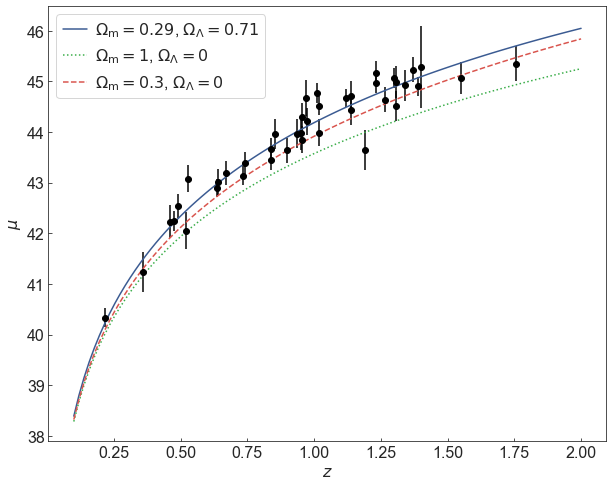

In [9]:
plt.figure(figsize=(10,8))
plt.errorbar(z,mu,yerr=sigmamu,fmt='o',color='black',label='_none')
plt.plot(zz,mu_best,linestyle='-',label=bestlabel,color=c1)
plt.plot(zz,mu_matter_flat,linestyle=':',label=mflatlabel,color=c2)
plt.plot(zz,mu_matter_open,linestyle='--',label=mopenlabel,color=c3)
plt.xlabel('$z$',fontsize=fontsize)
plt.ylabel('$\\mu$',fontsize=fontsize)
plt.legend(fontsize=fontsize,handletextpad=0.5, handlelength=1.5, frameon=True)

Next we will bin the data and plot the differences in distance modulus with respect to an empty universe model

In [27]:
# subtract an empty universe model from each distance modulus
# models
dm_best = distmod(dL_best) - distmod(dL_empty)
dm_matter_flat = distmod(dL_matter_flat) - distmod(dL_empty)
dm_matter_open = distmod(dL_matter_open) - distmod(dL_empty)
# data
dL_empty_z = empty.luminosity_distance(z)
d_mu = mu - distmod(dL_empty_z)

In [28]:
# now bin the data by redshift
# we'll just use the mean of the redshift and distance modulus in each bin
binsize = 0.26 # width of each bin in redshift
maxbin = 1.82 # maximum redshift of last bin
numbins = int(maxbin/binsize) # number of bins
bins = np.linspace(binsize,maxbin,numbins) # array giving the max redshift for each bin
# the digitize function gives us an array
# each element of the array is the index of the bin to which that 
# element of the redshift array belongs
inds = np.digitize(z,bins) 

# now we use the array of indices to get the mean redshift and distance modulus in each bin
# we also use error propagation to get the uncertainty on the binned distance modulus
def bindata(z,mu,sigmamu,bins,numbins):
    binned_z = np.zeros(len(bins))
    binned_mu = np.zeros(len(bins))
    binned_mu_err = np.zeros(len(bins))
    num_in_bins = np.zeros(len(bins))
    for i in np.arange(numbins):
        num_in_bins[i] = len(z[inds==i])
        binned_z[i] = z[inds==i].mean()
        binned_mu[i] = mu[inds==i].mean()
        binned_mu_err[i] = np.sqrt((sigmamu[inds==i]**2).sum())/num_in_bins[i]
    return binned_z, binned_mu, binned_mu_err, num_in_bins

binned_z = bindata(z,d_mu,sigmamu,bins,numbins)[0]
binned_dmu = bindata(z,d_mu,sigmamu,bins,numbins)[1]
binned_dmu_err = bindata(z,d_mu,sigmamu,bins,numbins)[2]

Now plot the binned data and the models. Note that we haven't fit any models to the data, although we could have. This is just an illustration of how various cosmological models compare to the data.

Text(0, 0.5, '$\\Delta$(m-M) (mag)')

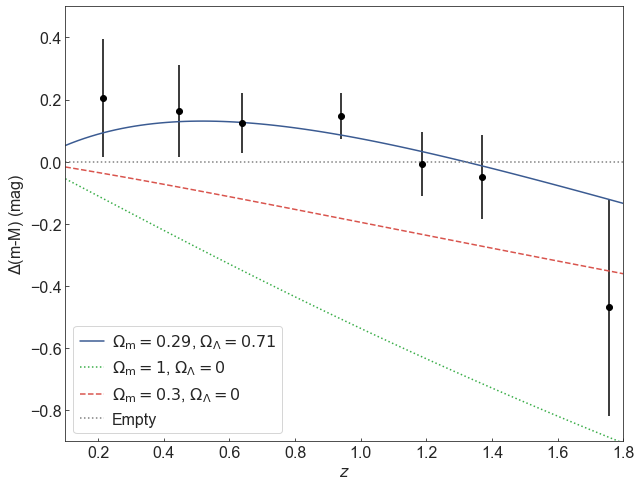

In [29]:
plt.figure(figsize=(10,8))
plt.errorbar(binned_z,binned_dmu,yerr=binned_dmu_err,fmt='o',color='k')
plt.plot(zz,dm_best,label=bestlabel,color=c1)
plt.plot(zz,dm_matter_flat,label=mflatlabel,linestyle=':',color=c2)
plt.plot(zz,dm_matter_open,label=mopenlabel,linestyle='--',color=c3)
plt.axhline(0,linestyle=':',color='gray',label='Empty')
plt.axis([0.1,1.8,-0.9,0.5])
plt.legend(loc=3,fontsize=fontsize,handletextpad=0.5, handlelength=1.5, frameon=True)
plt.xlabel('$z$',fontsize=fontsize)
plt.ylabel('$\\Delta$(m-M) (mag)', fontsize=fontsize)

The error bars on the first and last points are particularly large because there is only one point in each of those bins.

Finally, compare our result with Riess et al. 2007. Our binned data don't look the same because we aren't using the entire data set from their paper, and because we've made somewhat different choices in binning, but we find the same general trend. The supernovae are consistent with a model with current acceleration and previous deceleration.

<img src="https://iopscience.iop.org/article/10.1086/510378/fulltext/fg6.h.jpg" width="900">